In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/opt/homebrew/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 32
train_dl = DataLoader(train, batch_size=batch_size)
test_dl = DataLoader(test, batch_size=batch_size)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [5]:
for X, y in test_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [6]:
class NN(nn.Module):
    def __init__(self, activ=None):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 100),
            activ(),
            nn.Linear(100, 100),
            activ(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits


In [7]:
def train(train_dl, models, optims, epochs=5):
    print("train_dl\n", train_dl)
    print("models\n", models)
    plt.figure(figsize=(8,4))
    losses = [[], []]
    size = len(train_dl.dataset)
    # for mi in range(len(models)):
    for mi in range(len(models)):
        loss_fn = nn.CrossEntropyLoss()
        for t in range(epochs):
            print(f"Epoch {t+1}")

            models[mi].train()
            for batch, (X, y) in enumerate(train_dl):
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = models[mi](X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optims[mi].zero_grad()
                loss.backward()
                optims[mi].step()


                if batch % 100 == 0:
                    loss, current = loss.item(), batch * len(X)
                    #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    losses[mi].append(loss)
                    
    return losses

train_dl
models
 [NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
), NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)]
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


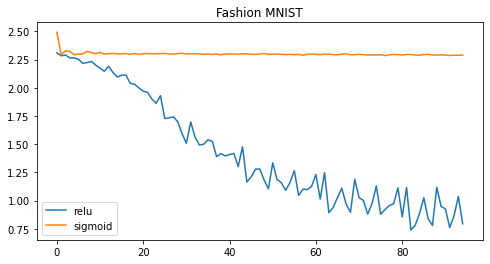

In [8]:
fashion_models = [NN(nn.ReLU).to(device), NN(nn.Sigmoid).to(device)]
fashion_relu, fashion_sigmoid = train(
  train_dl=train_dl,
  models=fashion_models,
  optims=[torch.optim.SGD(m.parameters(), lr=1e-3) for m in fashion_models])
plt.plot(fashion_relu, label='relu')
plt.plot(fashion_sigmoid, label='sigmoid')
plt.title("Fashion MNIST")
plt.legend()
plt.show()

In [9]:
train_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
train_mnist_dl = DataLoader(train_mnist, batch_size=batch_size)
test_mnist_dl = DataLoader(test_mnist, batch_size=batch_size)

train_dl
models
 [NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
), NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)]
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
train_dl
models
 [NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=

<Figure size 576x288 with 0 Axes>

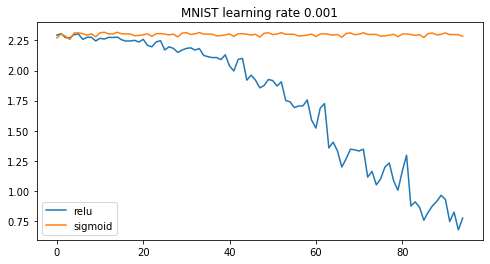

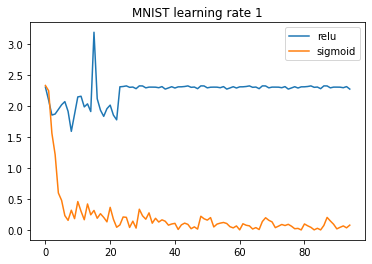

In [12]:
rr = []
lrs = [1e-3, 1]
for lr in lrs:
    mnist_models = [NN(nn.ReLU).to(device), NN(nn.Sigmoid).to(device)]
    mnist_results = train(
      train_dl=train_mnist_dl,
      models=mnist_models,
      optims=[torch.optim.SGD(m.parameters(), lr=lr) for m in mnist_models])
    rr.append(mnist_results)

for i in range(len(rr)):
    plt.plot(rr[i][0], label='relu')
    plt.plot(rr[i][1], label='sigmoid')
    plt.title("MNIST learning rate " + str(lrs[i]))
    plt.legend()
    plt.show()

> Apparently no change in Sigmoid vs ReLU between Fashion MNIST and MNIST **unless you change the learning rate**.